# Tweet Topic Modelling

In this notebook we'll model the important few topics in a single document, and look at how that changes over time. In our case since a single tweet is unlikely to have more than one topic, we will treat an entire __day of tweets__ as a document. The corpus consists of all 731 documents (365 days in 2019 and 366 days in 2020).

It will be interesting to see what the top 3 or 4 topics are each day, how that has changed over the last two years, and which topics have persisted.

In [1]:
import datetime
import os
import json
import itertools

import matplotlib.pyplot as plt
plt.style.use('seaborn')

### Loading from a corpus in chunks with gensim

[https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html](https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html)

Create a corpus which only opens documents when required.

In [2]:
from processing import StreamingCorpus

def head(corpus, n=10):
    return list(itertools.islice(corpus, n))

In [3]:
corpus = StreamingCorpus(data_dir='tweets_data')

Example (raw tweet content):

In [4]:
sample_files = [os.path.join('tweets_data', x) for x in os.listdir('tweets_data') if x.endswith('.json')][:3]

for file_loc in sample_files:     
    with open(file_loc, 'r') as f:
        lines = [line for line in f.read().split('\n') if len(line) > 0]
        document = ' '.join([json.loads(x)['content'] for x in lines])
        print(document[:100])

@ObiWokKanobe @carriesymonds @BorisJohnson OMG how could she bonk all that blubber.. @CPierceUK @dan
@BorisJohnson Dear Boris Johnson, I have to apprise you of a few facts which are testifying to a nuc
@RespectIsVital The award for despicable shithousery has to go to the currently invisible @BorisJohn


Example (normalized):

In [5]:
for i, doc in enumerate(corpus):
    if i == 3:
        break
    print(doc[:10])

['omg', 'could', 'bonk', 'blubber', 'guessing', 'right', 'long', 'got', 'someone', 'still']
['dear', 'apprise', 'fact', 'testifying', 'nuclear', 'war', 'peril', 'thanks', 'andrei', 'bystrov']
['award', 'despicable', 'shithousery', 'ha', 'go', 'currently', 'invisible', 'forgotten', 'horrid', 'scumbaggery']


In [6]:
first_five_documents = head(corpus, 5)
first_five_documents[2][:3]

['award', 'despicable', 'shithousery']

### Identify frequent collocations

Before feature engineering and vectorization, we want to extract some useful bi-gram based phrases from our tweets and remove some unnecessary terms. We leverage the `gensim.models.Phrases` class for this. This capability helps us automatically detect common phrases from a stream of sentences, which are typically multi-word expressions/word n-grams.

In [7]:
import gensim

bigram = gensim.models.Phrases(
    corpus, 
    min_count=1000,  # must appear at least this number of times in the entire corpus
    threshold=20,    # higher threshold fewer phrases
    delimiter=b'_'   # join bigrams with an underscore
)
bigram_model = gensim.models.phrases.Phraser(bigram)

Save bigram model for later.

In [8]:
bigram_model.save('bigram_model_tweets.sav')

In [10]:
bigram_corpus = StreamingCorpus(data_dir='tweets_data', phraser=bigram_model)

Some collocations it's identifying in the first document, dated 2019-01-01, are `united_kingdom`, `nh_billion` (NHS and billion), `january_owes`.

In [11]:
print(head(bigram_corpus, 5)[1][:100])

['dear', 'apprise', 'fact', 'testifying', 'nuclear', 'war', 'peril', 'thanks', 'andrei', 'bystrov', 'would', 'bit', 'odd', 'though', 'odd', 'getting', 'back', 'searching', 'name', 'least', 'distinguished', 'minister', 'never', 'apologise', 'opinion', 'letter', 'magnificent', 'though', 'glad', 'top', 'irrelevant', 'yes', 'sir', 'rebuild', 'better', 'european', 'market', 'trade', 'many', 'country', 'unite', 'friendship', 'good', 'trade', 'unite', '30pm', '2nd', 'january_owes', 'nh_billion', 'unite', 'country', 'kashmir', 'stand', 'sir', 'bring', 'kashmiri', 'unite', 'true', 'leave', 'united_kingdom', 'mean', 'united_kingdom', 'yes', 'sir', 'stay', 'eu', 'build', 'better', 'future', 'trade', 'agree', 'build', 'united', 'european', 'country', 'men', 'nationality', 'unite', 'friendship', 'peace', 'war', 'better', 'european', 'market', 'amen', 'sir', 'yes', 'sir', 'united', 'mean', 'unite', 'work', 'trade', 'nationality', 'unite', 'forgetting', 'medical', 'insurance', 'ehic', 'still']


## Create the training corpus

Create a dictionary representation of the documents (this stage can take a lot of time).

In [12]:
dictionary = gensim.corpora.Dictionary(document for document in bigram_corpus)

In [13]:
dictionary.save('full_dictionary.sav')

In [14]:
print('Total number of documents:', dictionary.num_docs)

Total number of documents: 731


In [15]:
dictionary.num_pos

138230667

The vocabulary is way too big - around 1 millon words.

In [16]:
print('Total Vocabulary Size:', len(dictionary))
print('Sample word to number mappings:', list(dictionary.items())[1000:1015])

Total Vocabulary Size: 958496
Sample word to number mappings: [(1000, 'hug'), (1001, 'huge'), (1002, 'human'), (1003, 'humanely'), (1004, 'humanist'), (1005, 'humiliates'), (1006, 'humiliation'), (1007, 'hundred'), (1008, 'hunger'), (1009, 'hunt'), (1010, 'hunter'), (1011, 'hunting'), (1012, 'husband'), (1013, 'hustings'), (1014, 'hypocrisy')]


What are the most common words in the first document (2019-01-01)?

In [17]:
bow_doc = [dictionary.doc2bow(text) for text in head(bigram_corpus, 1)][0]

In [18]:
most_common_few = sorted(bow_doc, key=lambda x: x[1], reverse=True)[:3]
print([(head(bigram_corpus, 1)[0][most_index], most_count) for most_index, most_count in most_common_few])

[('mordaunt', 77), ('long', 50), ('tear', 48)]


Note: [https://en.wikipedia.org/wiki/Penny_Mordaunt](https://en.wikipedia.org/wiki/Penny_Mordaunt)

Let's prune the dictionary, keeping terms which appear in at least 7 days and also only keep the 10000 most frequent terms.

In [19]:
dictionary.filter_extremes(no_below=7, keep_n=10000, no_above=0.95)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 10000


In [20]:
dictionary.save('filtered_dictionary.sav')

In [21]:
bow_doc = [dictionary.doc2bow(text) for text in head(bigram_corpus, 1)][0]

In [22]:
most_common_few = sorted(bow_doc, key=lambda x: x[1], reverse=True)[:10]
print([(head(bigram_corpus, 1)[0][most_index], most_count) for most_index, most_count in most_common_few])

[('opportunity', 48), ('observed', 10), ('lie', 8), ('financial', 8), ('tragus', 7), ('drowned', 7), ('sent', 7), ('value', 6), ('low', 5), ('charge', 5)]


Create a bag-of-words corpus based on this pruned dictionary.

In [23]:
from processing import BagOfWordsStreamingCorpus

In [24]:
bow_corpus = BagOfWordsStreamingCorpus(dictionary, phraser=bigram_model)

# Build a topic model

### Latent Dirichlet Allocation (LDA) models

LDA models are pretty popular for topic modelling, and can be seen as a form of dimensionality reduction. [https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

In [26]:
TOTAL_TOPICS = 6  # initialise number of topics

### MALLET

We'll train a model using MALLET for computational efficiency.

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip -q mallet-2.0.8.zip

In [32]:
MALLET_PATH = 'mallet-2.0.8\\bin\\mallet'

In [36]:
import os
os.environ['MALLET_HOME'] = 'C:\\Users\\ollie\\Code\\NLP\\mallet-2.0.8'

### Evaluating model performance
Since it's an unsupervised ML model, evaluating performance is a fairly tricky task. We don't have "truth" labels as to what the real N topics are.

`gensim` has an in-built Coherence Score used to measure the quality of topic models to some extent, the higher the coherence score the better. A set of statements is said to be _coherent_ if they support each other. We can also look at model perplexity, the lower the perplexity the better.

## Training
We'll train multiple models, optimising the coherence score over $N$ (the number of topics).

In [51]:
import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count, end_topic_count, step, cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm.tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [52]:
lda_models, coherence_scores = topic_model_coherence_generator(
    corpus=bow_corpus, texts=bigram_corpus, dictionary=dictionary, 
    start_topic_count=4, end_topic_count=15, step=1, cpus=4
)

100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [25:09:38<00:00, 7548.19s/it]


In [55]:
import pandas as pd
import numpy as np

coherence_df = pd.DataFrame({'Number of Topics': range(4, 16, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
11,15,0.5473
8,12,0.5453
6,10,0.5426
9,13,0.5412
10,14,0.5363
7,11,0.5347
5,9,0.5281
4,8,0.5065
2,6,0.4945
1,5,0.4906


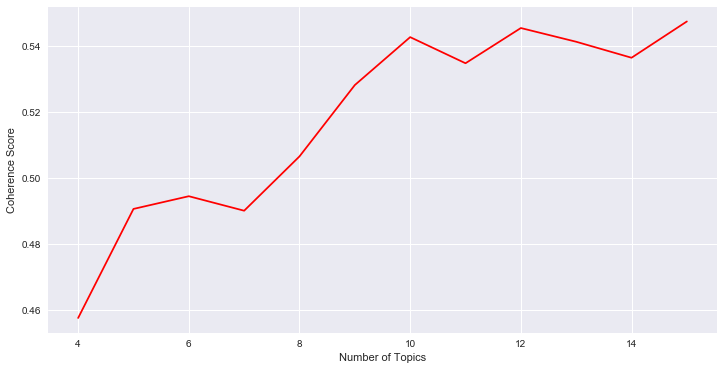

In [56]:
x_ax = range(4, 16, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')
plt.show()

Select best topic number as 10.

In [57]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 10].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

10

Save best LDA model.

In [58]:
best_lda_model.save('best_lda_model.sav')

In [59]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=10)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['protest', 'statue', 'thug', 'violence', 'riot', 'protester', 'khan', 'terrorist', 'race', 'nigeria']

Topic #2:
['cummings', 'dominic_cummings', 'lockdown', 'sack', 'dominiccummings', 'parent', 'drive', 'dom', 'mile', 'advisor']

Topic #3:
['well_soon', 'congratulation', 'la', 'recovery', 'en', 'se', 'da', 'el', 'wishing', 'praying']

Topic #4:
['ge2019', 'hospital', 'backboris', 'coward', 'nurse', 'hunt', 'liarjohnson', 'tonight', 'marr', 'scrutiny']

Topic #5:
['hs2', 'china', 'terrorist', 'iran', 'scottish', 'snp', 'nh_billion', 'muslim', 'ban', 'holiday']

Topic #6:
['lockdown', 'virus', 'mask', 'pub', 'pandemic', 'test', 'teacher', 'restriction', 'shop', 'student']

Topic #7:
['extension', 'backstop', 'mandate', 'queen', 'stopthecoup', 'dup', 'stopbrexit', 'peoplesvote', 'surrender', 'october']

Topic #8:
['ppe', 'virus', 'coronavirus', 'china', 'hospital', 'nurse', 'test', 'lockdown', 'pandemic', 'pay_rise']

Topic #9:
['christmas', 'tier', 'vaccine', 'lockdown', 'vir

___Notice how one of the topic contains a lot of Spanish words like "la", "en", "se", "el" etc. We should re-run this entire notebook but filtering the corpus to only be English language topics. We can do this as there is a field indicating language in the tweet json.___

The intertopic distance map is a visualization of the topics in a two-dimensional space . The area of these topic circles is proportional to the amount of words that belong to each topic across the dictionary. Intertopic map:

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [62]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(
    gensim.models.wrappers.ldamallet.malletmodel2ldamodel(best_lda_model), 
    bow_corpus, 
    dictionary
)
pyLDAvis.save_html(vis, 'LDAvis_plot.html')
vis

C:\Users\ollie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\ollie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\ollie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\ollie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.001245 -0.055721       1        1  17.821844
4      0.008700 -0.051049       2        1  17.693761
5      0.066617  0.041346       3        1  13.284752
9      0.041365  0.133611       4        1  10.758886
3      0.035032 -0.046250       5        1  10.628477
7      0.051161  0.055660       6        1   8.809828
8      0.018830  0.011447       7        1   7.221588
1      0.077514  0.046433       8        1   5.726298
0      0.038582 -0.156061       9        1   4.964028
2     -0.336557  0.020583      10        1   3.090539, topic_info=     Category           Freq              Term          Total  loglift  \
term                                                                     
2982  Default  135247.000000          cummings  135247.000000  30.0000   
9135  Default  226591.000000          lockdown  226591.000000  29.0000   
9689  Default   49402.000000         well_soon   49402.000000  28.0000   
9998  Default  112747.000000       coronavirus  112747.000000  27.0000   
6361  Default  167767.000000             virus  167767.000000  26.0000   
1830  Default   54131.000000         christmas   54131.000000  25.0000   
1242  Default   37043.000000    congratulation   37043.000000  24.0000   
3131  Default   49550.000000                la   49550.000000  23.0000   
9757  Default   54787.000000               ppe   54787.000000  22.0000   
3522  Default   39047.000000  dominic_cummings   39047.000000  21.0000   
9908  Default   63473.000000           vaccine   63473.000000  20.0000   
1688  Default   36805.000000              tier   36805.000000  19.0000   
8038  Default   29335.000000          recovery   29335.000000  18.0000   
2115  Default   33484.000000           protest   33484.000000  17.0000   
1983  Default   92189.000000          hospital   92189.000000  16.0000   
4209  Default   31312.000000                en   31312.000000  15.0000   
836   Default   37199.000000              sack   37199.000000  14.0000   
179   Default   79091.000000             china   79091.000000  13.0000   
2227  Default   94245.000000              test   94245.000000  12.0000   
2781  Default   34763.000000         stay_home   34763.000000  11.0000   
9704  Default   80253.000000          pandemic   80253.000000  10.0000   
3182  Default   48977.000000             nurse   48977.000000   9.0000   
5969  Default   52520.000000              mask   52520.000000   8.0000   
3012  Default   21404.000000   dominiccummings   21404.000000   7.0000   
8537  Default   18027.000000            statue   18027.000000   6.0000   
4678  Default   51460.000000               pub   51460.000000   5.0000   
3340  Default   55997.000000           testing   55997.000000   4.0000   
2651  Default   55201.000000            parent   55201.000000   3.0000   
7075  Default   22635.000000            ge2019   22635.000000   2.0000   
2156  Default   21276.000000                se   21276.000000   1.0000   
...       ...            ...               ...            ...      ...   
732   Topic10    6131.474274               por   10038.275961   2.9839   
8742  Topic10     855.055643               ter    1405.524270   2.9798   
4540  Topic10    1417.941735               nie    2347.396855   2.9727   
7644  Topic10     935.759819               lui    1581.470304   2.9521   
373   Topic10    1257.554954              este    2147.257242   2.9418   
3724  Topic10    8100.043238              pray   13852.171365   2.9403   
7650  Topic10    3151.549173              mais    5441.771056   2.9306   
8131  Topic10    7777.226532         god_bless   13549.525858   2.9217   
7641  Topic10    4140.430728                lo    7223.352455   2.9203   
260   Topic10    9989.951170                da   18504.603160   2.8604   
972   Topic10    5550.199888                te   10154.372223   2.8728   
2156  Topic10   10967.595435                se   2127

Topic 10 annoyingly is the one with all the Spanish words in. I think it's worth retraining / re-running the __entire__ notebook with English-only, to see the intertopic map visualisation when the principal components aren't representing Spanish vs English. But let's continue for now and see what the topics-over-time dynamic is.

Let's look at, for each document (day of tweets), what are the main topics.

In [64]:
lda_model_results = best_lda_model[bow_corpus]

In [65]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in lda_model_results]

In [69]:
len(corpus_topics)

731

Try out different values of `topn`.

In [77]:
TOPICS = [
    ', '.join([term for term, _ in best_lda_model.show_topic(n, topn=11)])
    for n in range(0, best_lda_model.num_topics)
]

In [78]:
TOPICS

['protest, statue, thug, violence, riot, protester, khan, terrorist, race, nigeria, weekend',
 'cummings, dominic_cummings, lockdown, sack, dominiccummings, parent, drive, dom, mile, advisor, durham',
 'well_soon, congratulation, la, recovery, en, se, da, el, wishing, praying, prayer',
 'ge2019, hospital, backboris, coward, nurse, hunt, liarjohnson, tonight, marr, scrutiny, toriesout',
 'hs2, china, terrorist, iran, scottish, snp, nh_billion, muslim, ban, holiday, india',
 'lockdown, virus, mask, pub, pandemic, test, teacher, restriction, shop, student, holiday',
 'extension, backstop, mandate, queen, stopthecoup, dup, stopbrexit, peoplesvote, surrender, october, nh_billion',
 'ppe, virus, coronavirus, china, hospital, nurse, test, lockdown, pandemic, pay_rise, patient',
 'christmas, tier, vaccine, lockdown, virus, fish, oven_ready, biden, xmas, fishing, pandemic',
 'lockdown, coronavirus, virus, stay_home, lock, test, staff, spread, pier, essential, italy']

In [80]:
TOPIC_DESCRIPTIONS = {
    1: 'BLM protests',
    2: 'Dominic Cummings',
    3: 'Get well soon / Spanish text',
    4: 'Election-related (#BackBoris / #LiarJohnson)',
    5: 'Policy-related',
    6: 'Lockdown (masks, pubs)',
    7: 'Brexit',
    8: 'Coronavirus / Hygiene',
    9: 'Vaccine',
    10: 'Lockdown (stay home, essential travel)'
}
"""
Human-labelled topic descriptions. It helps that the topics are fairly interpretable.
There are some topics which are very related (for example, Lockdown and Coronavirus) but
the keywords suggest they are talking about the topic from two different angles (in this
example, restrictive policies and the virus itself).
"""

'\nHuman-labelled topic descriptions. It helps that the topics are fairly interpretable.\nThere are some topics which are very related (for example, Lockdown and Coronavirus) but\nthe keywords suggest they are talking about the topic from two different angles (in this\nexample, restrictive policies and the virus itself).\n'

In [84]:
import os
from utils import get_date_from_file_loc

def format_topics_sentences(lda_model_results, corpus, data_dir='tweets_data'):

    files_lst = [os.path.join(data_dir, x) 
                      for x in os.listdir(data_dir) if x.endswith('.json')]
    
    corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in lda_model_results]
    topic_terms = [', '.join([term for term, wt in topic])  
                              for topic in topics]
    
    corpus_topic_df = pd.DataFrame()
    corpus_topic_df['document_id'] = range(0, len(files_lst))
    corpus_topic_df['date'] = [get_date_from_file_loc(filename) for filename in files_lst]
    
    corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
    corpus_topic_df['Dominant Topic Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
    corpus_topic_df['Dominant Topic Label'] = [TOPIC_DESCRIPTIONS[item[0]+1] for item in corpus_topics]
    corpus_topic_df['Dominant Topic Description'] = [TOPICS[item[0]] for item in corpus_topics]
    
    return corpus_topic_df 

In [85]:
corpus_topic_df = format_topics_sentences(lda_model_results, bow_corpus)

### Most representative day for a given topic

In [93]:
corpus_topic_df.sort_values('Dominant Topic Contribution %', ascending=False)\
    .groupby('Dominant Topic').head(1).sort_values('date')

,document_id,date,Dominant Topic,Dominant Topic Contribution %,Dominant Topic Label,Dominant Topic Description
266,266,2019-09-24,7,90.42,Brexit,"extension, backstop, mandate, queen, stoptheco..."
325,325,2019-11-22,4,82.79,Election-related (#BackBoris / #LiarJohnson),"ge2019, hospital, backboris, coward, nurse, hu..."
374,374,2020-01-10,5,96.14,Policy-related,"hs2, china, terrorist, iran, scottish, snp, nh..."
448,448,2020-03-24,10,87.87,"Lockdown (stay home, essential travel)","lockdown, coronavirus, virus, stay_home, lock,..."
461,461,2020-04-06,3,62.21,Get well soon / Spanish text,"well_soon, congratulation, la, recovery, en, s..."
467,467,2020-04-12,8,65.94,Coronavirus / Hygiene,"ppe, virus, coronavirus, china, hospital, nurs..."
509,509,2020-05-24,2,81.66,Dominic Cummings,"cummings, dominic_cummings, lockdown, sack, do..."
529,529,2020-06-13,1,73.51,BLM protests,"protest, statue, thug, violence, riot, protest..."
594,594,2020-08-17,6,65.55,"Lockdown (masks, pubs)","lockdown, virus, mask, pub, pandemic, test, te..."
720,720,2020-12-21,9,74.25,Vaccine,"christmas, tier, vaccine, lockdown, virus, fis..."


### Dominant topic over time

In [210]:
import matplotlib.colors as mcolors

COLOUR_CODES = list(mcolors.TABLEAU_COLORS.values())

C:\Users\ollie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


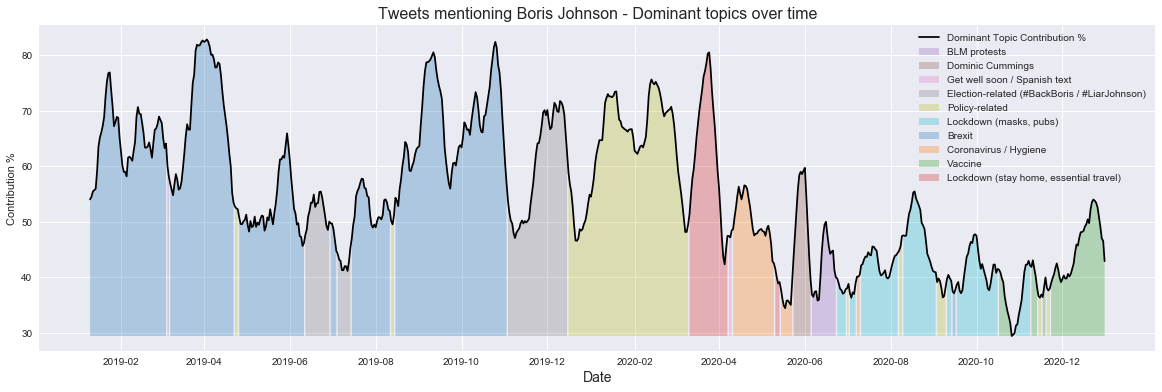

In [228]:
from scipy.stats import mode
corpus_topic_df['dominant_topic_rolling'] = corpus_topic_df['Dominant Topic'].rolling(5).apply(lambda x: mode(x)[0])
corpus_topic_df['contribution_rolling'] = corpus_topic_df['Dominant Topic Contribution %'].rolling(10).mean()
corpus_topic_df['date'] = pd.to_datetime(corpus_topic_df['date'])

ax = corpus_topic_df.set_index('document_id')['contribution_rolling'].plot(figsize=(20, 6), color='black')

for i in range(len(TOPICS)):
    ax.fill_between(
        range(len(corpus_topic_df['document_id'])), 
        corpus_topic_df['contribution_rolling'].min(skipna=True), 
        corpus_topic_df['contribution_rolling'],
        where=(corpus_topic_df['dominant_topic_rolling'] == i+1),
        alpha=0.3,
        facecolor=COLOUR_CODES[(i+4)%len(COLOUR_CODES)]
    )
    
ax.legend(labels=['Dominant Topic Contribution %']+list(TOPIC_DESCRIPTIONS.values()))
ax.set_title('Tweets mentioning Boris Johnson - Dominant topics over time', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Contribution %')

# Format x ticks 
tick_filter = (corpus_topic_df.date.dt.day == 1) & (corpus_topic_df.date.dt.month % 2 == 0)
plt.xticks(corpus_topic_df.loc[tick_filter, 'document_id'], corpus_topic_df.loc[tick_filter, 'date'].dt.strftime('%Y-%m'))

plt.savefig('Dominant_topics_over_time.png')
plt.show()